In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np 
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

In [ ]:
TRAIN_PATH = ("/content/drive/MyDrive/COMP576 Final Project/Data/Training/Training")
# to be modifed
TEST_PATH = ("/content/drive/MyDrive/COMP576 Final Project/Data/Testing")
GPATH = ("/content/drive/MyDrive/COMP576 Final Project/GAN")

In [ ]:
def load_data(path, img_size):

    X = []
    Y = []
    labels = dict()
    ilabel = 0

    for label in sorted(os.listdir(path)):
        if not label.startswith('.'):
            labels[ilabel] = label
            for img_file in os.listdir(path + '/' + label):
                if not img_file.startswith('.'):
                    img = cv2.imread(path + '/' + label + '/' + img_file)
                    img = img.astype('float32') / 255
                    X.append(cv2.resize(img, img_size, interpolation = cv2.INTER_AREA))
                    Y.append(ilabel)
        ilabel += 1
        
    X = np.array(X)
    Y = np.array(Y)
    print(f'{len(X)} images loaded from {path}.')
    return X, Y, labels

In [ ]:
def load_gdata(path, img_size, label, ilabel):
    X = []
    Y = []
    
    for img_file in os.listdir(path + '/G' + label):
        if not img_file.startswith('.'):
            img = cv2.imread(path + '/G' + label + '/' + img_file)
            img = img.astype('float32') / 255
            X.append(cv2.resize(img, img_size, interpolation = cv2.INTER_AREA))
            Y.append(ilabel)
    
    X = np.array(X)
    Y = np.array(Y)
    print(f'{len(X)} images loaded. Label = {label}. Generated by GAN.')
    return X, Y

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
img_size = (48, 48)

In [ ]:
X_train, Y_train, labels_train = load_data(TRAIN_PATH, img_size)

28293 images loaded from /content/drive/MyDrive/COMP576 Final Project/Data/Training/Training.


In [ ]:
X_gtrain0, Y_gtrain0 = load_gdata(GPATH, img_size, "Happy", 2)

2000 images loaded. Label = Happy. Generated by GAN.


In [ ]:
X_test, Y_test, labels_test = load_data(TEST_PATH, img_size)

7067 images loaded from /content/drive/MyDrive/COMP576 Final Project/Data/Testing.


In [ ]:
X_train = np.concatenate((X_train, X_gtrain0))
Y_train = np.concatenate((Y_train, Y_gtrain0))

In [ ]:
labels_train

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [ ]:
X_train.shape, Y_train.shape

((30293, 48, 48, 3), (30293,))

In [ ]:
from keras.utils.np_utils import to_categorical
Y_train_categorized = to_categorical(Y_train, num_classes=6)
Y_train_categorized.shape

(30293, 6)

In [ ]:
Y_test_categorized = to_categorical(Y_test, num_classes=6)
Y_test_categorized.shape

(7067, 6)

In [ ]:
from keras.applications.vgg16 import VGG16

# to be modifed
base_model = VGG16(
    weights = None,
    include_top = False,
    input_shape = img_size + (3,)
)

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
NUM_CLASSES = 6

# to be modifed
model = keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1000)              513000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 6006      
                                                                 
Total params: 15,233,694
Trainable params: 15,233,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def deep_model(model, X_train, Y_train_categorized, epochs, batch_size):

    model.compile(
        # modified
        loss='categorical_crossentropy',
        optimizer=RMSprop(learning_rate=1e-4),
        metrics=['accuracy'])

    history = model.fit(X_train
                       , Y_train_categorized
                       , epochs=epochs
                       , batch_size=batch_size
                       , validation_split = 0.1
                       , verbose=1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return history

Epoch 1/50
398/398 [==============================] - 29s 69ms/step - loss: 0.1350 - accuracy: 0.9805 - val_loss: 1.7712 - val_accuracy: 0.8163
Epoch 2/50
398/398 [==============================] - 26s 65ms/step - loss: 0.0619 - accuracy: 0.9856 - val_loss: 1.5437 - val_accuracy: 0.7894
Epoch 3/50
398/398 [==============================] - 26s 64ms/step - loss: 0.0618 - accuracy: 0.9861 - val_loss: 25.2304 - val_accuracy: 0.8184
Epoch 4/50
398/398 [==============================] - 26s 64ms/step - loss: 0.1457 - accuracy: 0.9854 - val_loss: 2.5744 - val_accuracy: 0.8569
Epoch 5/50
398/398 [==============================] - 26s 65ms/step - loss: 0.7076 - accuracy: 0.9871 - val_loss: 2.9118 - val_accuracy: 0.3827
Epoch 6/50
398/398 [==============================] - 26s 65ms/step - loss: 0.0614 - accuracy: 0.9879 - val_loss: 3.0033 - val_accuracy: 0.8530
Epoch 7/50
398/398 [==============================] - 26s 65ms/step - loss: 0.0632 - accuracy: 0.9865 - val_loss: 3.8177 - val_accuracy

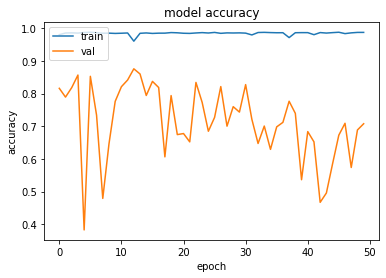

In [ ]:
epochs = 50
batch_size = 64

fitted_model = deep_model(model, X_train, Y_train_categorized, epochs, batch_size)

In [ ]:
predictions = model.predict(X_test)
Y_pred = [np.argmax(probas) for probas in predictions]

accuracy = accuracy_score(Y_test, Y_pred)
print('Test Accuracy = %.2f' % accuracy)

221/221 [==============================] - 3s 12ms/step
Test Accuracy = 0.58


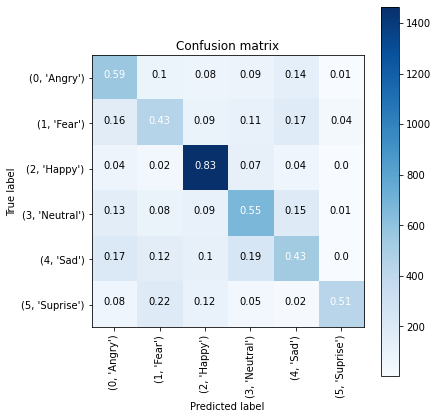

In [ ]:
confusion_mtx = confusion_matrix(Y_test, Y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels_test.items()), normalize=True)